In [0]:
# General
import pandas as pd
import numpy as np
from google.colab import drive
import os
import joblib
import re
import io

# Text cleaning
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# from nltk.stem.snowball import SnowballStemmer

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# from sklearn.feature_selection import SelectKBest
# from sklearn.decomposition import TruncatedSVD

# Modeling
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Plotting
from matplotlib import pyplot as plt
import seaborn as sn
from yellowbrick.text import FreqDistVisualizer


# Read Data

> Read data from Google Drive. Dataset is from Kaggle can be found here: https://www.kaggle.com/datasnaek/mbti-type

In [0]:
drive.mount('/content/drive') 
path = os.path.expanduser(f'/content/drive/My Drive/Colab Notebooks/predict_mbti/')
df = pd.read_csv(os.path.join(path, 'Data/mbti_1.csv'))

# Data Preprocessing

> Take out website links and non-alphabet characters, replace some apostrophes with full words, stem words

In [3]:
def dineise_clean_text(row):
    # Take out website links in each row
    row = re.sub(r'(?<=.)*https?:\/\/[a-zA-Z0-9\/\.\?\-=_]+(?=.*)', '', row)  # Take out website links
    row = re.sub(r'(?<=.)*[a-zA-Z0-9\/\.\?\-=_]+(jpg|png|gif|html|php)(?=.*)', '', row)     # Take out png, jpg, gif, etc.. links

    # Replace some apostrophes
    replace_list = {r"i'm": 'i am', r"'re": ' are', r"let’s": 'let us',
                    r"'s":  ' is', r"'ve": ' have', r"can't": 'can not',
                    r"cannot": 'can not', r"shan’t": 'shall not', r"n't": ' not',
                    r"'d": ' would', r"'ll": ' will', r"'scuse": 'excuse', '\s+': ' '}
    row = row.lower()  #lowercase all words in sentence
    # Iterate through the replacement list and replace any match 
    for rep_word in replace_list:
        row = row.replace(rep_word, replace_list[rep_word])

    # Replace any character that's NOT a letter with a space
    row = re.sub(r"[^A-Za-z]+", ' ', row)

    # Split words into a list based on delimiters \s and \|
    row_split = re.split(r'[\s\|]', row)

    # Stem each word in row
    # **Could try SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    new_row = ''
    for word in row_split:
        new_word = lemmatizer.lemmatize(word)
        new_row = new_row +' '+ new_word
        
    return new_row

X = df['posts'].apply(lambda x: dineise_clean_text(x))
y = df['type']
X

0         enfp and intj moment sportscenter not top te...
1         i am finding the lack of me in these post ve...
2         good one of course to which i say i know tha...
3         wouldear intp i enjoyed our conversation the...
4         you are fired that is another silly misconce...
                              ...                        
8670      ixfp just because i always think of cat a fi...
8671      iso if this thread already exists someplace ...
8672      iso many question when i do these thing i wo...
8673      i am very conflicted right now when it come ...
8674      it ha been too long since i have been on per...
Name: posts, Length: 8675, dtype: object

# Data Exploration

### Explore number of classes

> Data seems to be quite imbalanced with some classes have very high counts while others have low counts

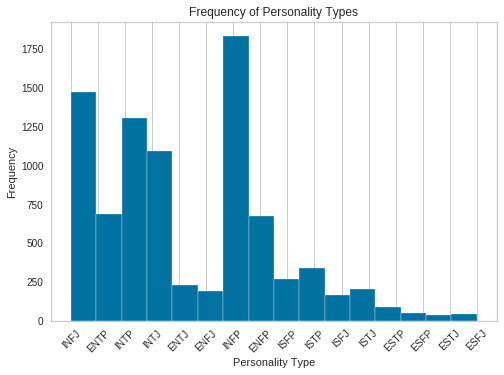

In [4]:
#Plot the 16 personalities frequency
def dineise_plot_classes(column):
  plt.hist(column, edgecolor='white', bins=16)
  plt.xticks(rotation = 45)
  plt.grid(axis='y')
  plt.xlabel('Personality Type')
  plt.ylabel('Frequency')
  plt.title('Frequency of Personality Types')
  plt.show()
dineise_plot_classes(df['type'])

> We also have much more introverted data than we do with extroverted data. Same for intuitive vs sensing

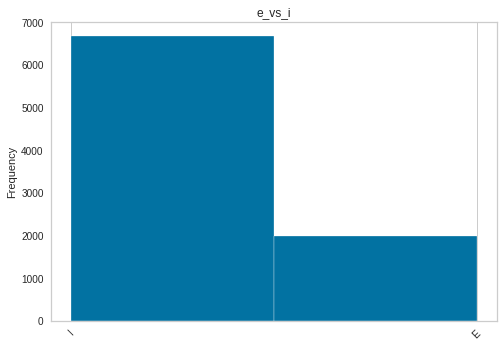

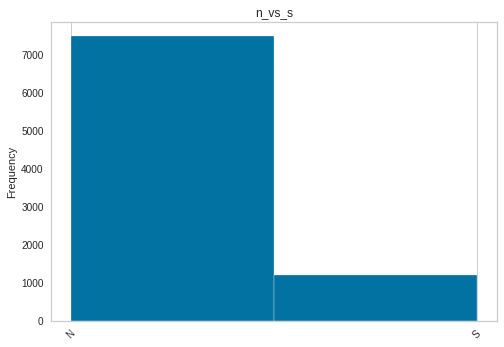

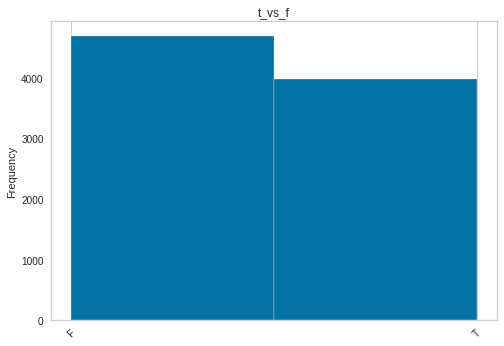

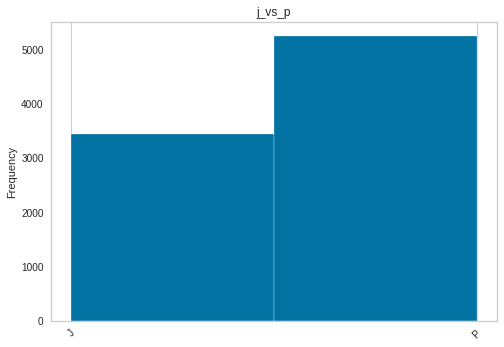

In [5]:
def dineise_plot_4personalities(column):
  plt.hist(df[column], edgecolor='white', bins=2)
  plt.xticks(rotation = 45)
  plt.grid(axis='y')
  plt.ylabel('Frequency')
  plt.title(column)
  plt.show()

# Break personality into 4 categories
df = df.assign(e_vs_i= df['type'].str[0],
          n_vs_s= df['type'].str[1],
          t_vs_f= df['type'].str[2],
          j_vs_p= df['type'].str[3])

#Plot each personality type
dineise_plot_4personalities('e_vs_i')
dineise_plot_4personalities('n_vs_s')
dineise_plot_4personalities('t_vs_f')
dineise_plot_4personalities('j_vs_p')

### Explore number of words in each row

> Number of samples/median-words-per-sample ratio is < 1500, so we go with Multiple Layer Perceptron model. If samples/median-words-per-sample ratio is > 1500, then we can consider more complex models like LSTM, BRNN, etc.

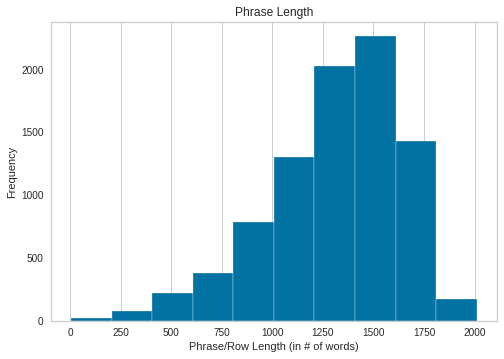

max phrase len: 2011 words
median phrase len: 1368.0 words
number of samples: 8675 samples
samples/median-words-per-sample ratio: 6.341374269005848


In [6]:
phrase_len = X.apply(lambda p: len(p.split(' ')))  #Split each row into words separated by a space
max_phrase_len = phrase_len.max()
median_phrase_len = np.median(phrase_len)

plt.hist(phrase_len, edgecolor='white')
plt.grid(axis='y')
plt.xlabel('Phrase/Row Length (in # of words)')
plt.ylabel('Frequency')
plt.title('Phrase Length')
plt.show()

print('max phrase len: {} words'.format(max_phrase_len))
print('median phrase len: {} words'.format(median_phrase_len))
print('number of samples: {} samples'.format(df.shape[0]))
print("samples/median-words-per-sample ratio: {}". format(df.shape[0]/median_phrase_len))



### Plot frequency of word occurence

> Plot words that occur frequently if we take out stop words (I, is, etc.). Also, we can see the vocabulary size

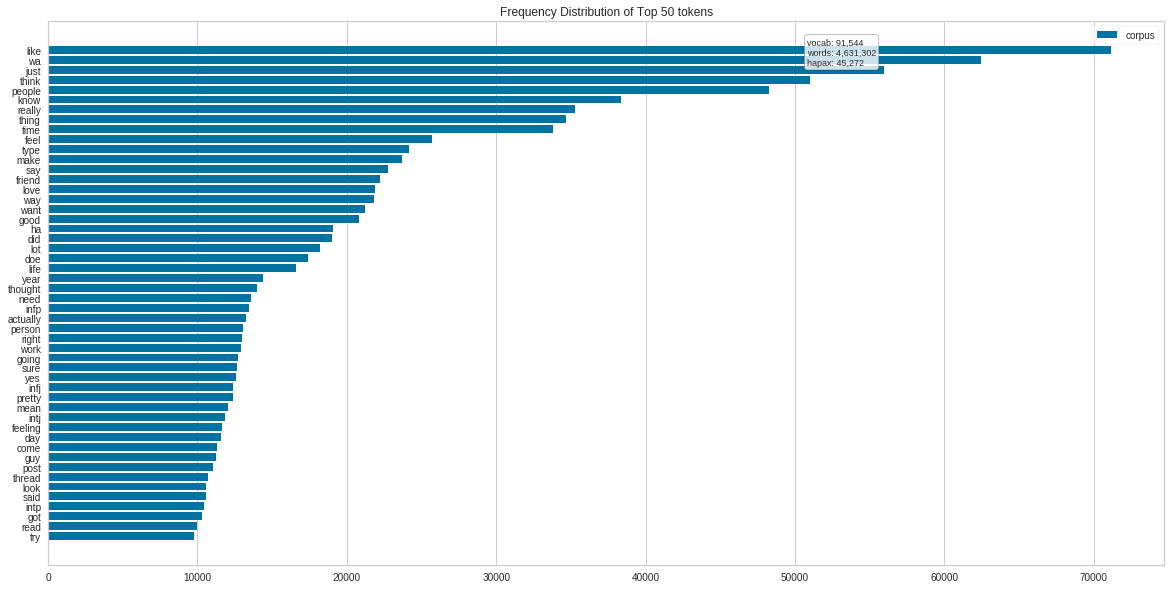

In [7]:
def dineise_plot_distribution_of_words(X, n_words = 50):
  kwargs = {
              'ngram_range': (1, 1),
              'dtype': 'int32',
              'strip_accents': 'unicode',
              'decode_error': 'replace',
              'analyzer': 'word',  # Split text into word tokens.
              'stop_words': 'english'  #Take out stop_words (I, is, etc...)
      }
  count_vec = CountVectorizer(**kwargs)
  count = count_vec.fit_transform(X)
  features = count_vec.get_feature_names()  #Get a list of all the words

  f, ax = plt.subplots(figsize=(20,10))
  visualizer = FreqDistVisualizer(features=features, ax=ax, n=n_words)
  visualizer.fit(count)
  visualizer.poof(outpath=os.path.join(path,'Output/Frequency distribution of n-grams.pdf'))

dineise_plot_distribution_of_words(X)

# Feature Engineering

### Tf-Idf on X

> Multiple Layer Perceptron works well with bags-of-words feature engineering. We will use tf-idf which not only count word occurence, but also take into account the frequency of their occurence.

In [8]:
input_features=1500
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=input_features)  
X_tf = vectorizer.fit_transform(X)   #.toarray()
print('tfidf shape', X_tf.shape)

tfidf shape (8675, 1500)


### Oversampling SMOTE


> Because the data is very skewed, we will oversample using the SMOTE method (based on KNN technique)

> Now, our sample size went from 8675 samples to 29312 samples. We can see that each personality type has the same frequency now thanks to SMOTE



X_smote shape (29312, 1500)
y_smote shape (29312,)


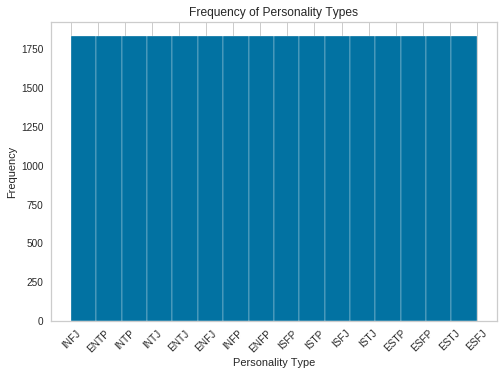

In [9]:
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_sample(X_tf, y)

print('X_smote shape', X_smote.shape)
print('y_smote shape', y_smote.shape)
dineise_plot_classes(y_smote)

### Encoding y


> Encode y and then make it one-hot encoding



In [0]:
encoder = LabelEncoder()
y_en = encoder.fit_transform(y_smote)  #y_smote is string data, need to encode into numerical data
y_cate = to_categorical(y_en)  #Be sure that the data is not seen as numerical, but as category. This transforms into one-hot encoding

# Modeling

###Multiple Layer Perceptron

Methods I tried to improve model
> Methods that improved overfitting
  * Reducing max_features from 91K to 1500 features in Tf-idf
  * Adding Dropout of 0.2 for each layer
  * Oversample minority data

> Methods that improved model performance
  * Increasing number of units in first layer
  * Adding one more dense layer
  * Oversample minority data
  
> Methods that did not improve model performance or overfitting
  * Using SVD to reduce to 500 features
  * n-gram range of (1,2)
  * Using K-Best to pick top 500 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                96064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_

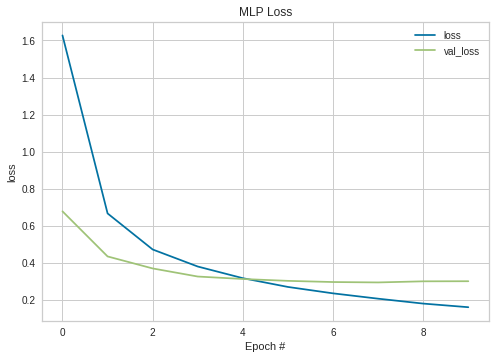

In [11]:
def mlp_model(X, y, units_in_layers, n_features, n_epochs=10, batch_size=32, metric='accuracy', opt='Adam'):

  # Train: 80%; Test: 15%; Blind: 5%
  X_train, X_bt, y_train, y_bt = train_test_split(X, y, test_size=0.20, random_state=0, stratify = y)
  X_test, X_blind, y_test, y_blind = train_test_split(X_bt, y_bt, test_size=0.25, random_state=0, stratify = y_bt)

  #Initiate a sequential model
  mlp = Sequential()
  
  #Iterate through the number of layers
  for n_units in units_in_layers:
    mlp.add(Dense(n_units, input_shape=(n_features,)))
    mlp.add(Dropout(0.2))
    mlp.add(Activation('relu'))

  #Add last layer of dense to get number of categories and softmax
  mlp.add(Dense(y.shape[1]))  #Get number of categories from y
  mlp.add(Activation('softmax'))
  mlp.summary()  #Shows summary of model
  mlp.compile(loss='categorical_crossentropy',
      optimizer=opt,
      metrics=[metric])

  history = mlp.fit(
      X_train,
      y_train,
      batch_size=batch_size,
      validation_data=(X_test, y_test),
      epochs = n_epochs,
      verbose=1)
  
  # Plot Model Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'], '')
  plt.title('MLP Loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.legend(['loss', 'val_loss'])
  plt.show()
  
  return mlp, X_blind, y_blind

mlp, X_blind, y_blind = mlp_model(X_smote, y_cate, units_in_layers=[64,32], n_features=input_features)


> We see that with loss decreased significantly with 10 epochs and accuracy for both train and test sets are >=90%

### Evaluate Blind Set

> Predict on blind set and get back labels 

In [0]:
pred = mlp.predict_classes(X_blind)  #Gives back numerical encoding
pred_labels = encoder.inverse_transform(pred)  #Inverse transform the numerical encoding into labels
y_blind_labels = encoder.inverse_transform(y_blind.argmax(axis=1))  #y_blind is one-hot encoding. Transform it back to numerical encoding and then labels

> Compute and plot confusion matrix on blind set. Compute the accuracy and report on blind set. We see that our train, test, and blind set accuracy were each around 90%!

Accuracy on blind set: 0.907912687585266
Classification Report on blind set 
               precision    recall  f1-score   support

        ENFJ       0.97      1.00      0.98        92
        ENFP       0.84      0.92      0.88        91
        ENTJ       0.98      0.98      0.98        91
        ENTP       0.84      0.89      0.86        92
        ESFJ       0.98      1.00      0.99        92
        ESFP       1.00      1.00      1.00        91
        ESTJ       0.99      1.00      0.99        92
        ESTP       0.99      1.00      0.99        91
        INFJ       0.69      0.66      0.68        92
        INFP       0.84      0.66      0.74        92
        INTJ       0.74      0.74      0.74        92
        INTP       0.81      0.75      0.78        91
        ISFJ       0.99      0.99      0.99        92
        ISFP       0.97      0.99      0.98        91
        ISTJ       0.93      0.99      0.96        92
        ISTP       0.96      0.96      0.96        92

  

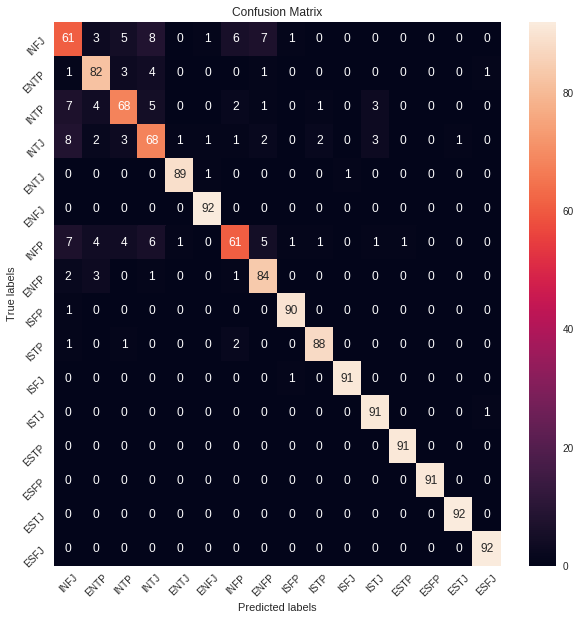

In [13]:
f, ax = plt.subplots(figsize=(10,10))
#Compute cm
cm = confusion_matrix(y_blind_labels, pred_labels, labels= df['type'].unique())
#Plot heat map and put numbers in cm cells
sn.heatmap(cm, annot=True)  
#Add labels
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); ax.set_title('Confusion Matrix'); 
#Add tick labels
ax.set_xticklabels(df['type'].unique(), rotation=45); ax.set_yticklabels(df['type'].unique(), rotation=45);  
#Bug in matplotlib cutting off ends of image, this accounts for the bug
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)   
#Save cm
f.savefig(os.path.join(path,'Output/Confusion_matrix.pdf'))

print('Accuracy on blind set:', accuracy_score(y_blind_labels, pred_labels))
print('Classification Report on blind set \n', classification_report(y_blind_labels, pred_labels))


### Predict random texts

> Just a few real life examples of facebook texts of friends who know their own MBTI. Keep in mind, the data we trained on is from a personality forum, not facebook postings. But the model also performs decently here.

In [0]:
def dineise_predict(name, text, actual):
  text_cleaned = dineise_clean_text(text)
  text_vec = vectorizer.transform([text_cleaned])  #Transform text into tfidf 
  text_pred = mlp.predict_classes(text_vec)  #Output numerical encoding of class
  text_en = encoder.inverse_transform(text_pred)  #Inverse transform the numerical encoding into the label
  print("Model classified {0} to be {1}. {0} is actually {2}.".format(name, text_en[0],actual ))

In [0]:

Lexi_text = 'NEW YORK CITY TRIP VLOG. it is 40min long and more of a documentary at this point, so just watch 14:35 - 20:26 for Patrick and Hannahs wedding banquet!!! if you are my real friend you would watch 11:05 - the end :O jk there is a table of contents in the description with time stamps'
Dineise_text = 'Nobody does fb status anymore but I don’t have an insta and need an outlet Somebody stole my honey wheat bread at work today you. do. not. steal. peoples. honey. wheat. bread. noooooooooooooooo I’ll give you some if you ask'
Jess_text = "LOL LEE HYORIII w o w this performance has all the feeeeelz T.T Big Bang looks so clean and cute here LOL and !!!u went to a Taeyang concert too!!! These are the songs jacob and I will play once in a while and go wow... old kpop was the best LOL"
Kristin_text = "I love to read. Somehow I had forgotten that in college. Since last year, this is a compilation of some books I’ve read - listed in chronological order - that have challenged, shaped, and/or broadened my views as I wrestle to understand what a life well-lived means to me. They are A++ reads and I’d be glad to tell you why if you’re curious. But I am mainly posting this because I am hungry and looking for more recommendations!! I don’t even know how little I know so I am searching for more A++ reads that challenged/shaped/broadened your views (tell me why too!) let me know in the comments please 🤓📚"



In [18]:
dineise_predict("Lexi", Lexi_text, actual="INTJ")
dineise_predict("Dineise", Dineise_text, actual="ENTJ")
dineise_predict("Jess", Jess_text, actual="ENFP")
dineise_predict("Kristin", Kristin_text, actual="INFJ")


Model classified Lexi to be INTJ. Lexi is actually INTJ.
Model classified Dineise to be ISTJ. Dineise is actually ENTJ.
Model classified Jess to be ENFP. Jess is actually ENFP.
Model classified Kristin to be ENFP. Kristin is actually INFJ.


# Word Embeddings

### Extract embeddings

> Extract embeddings of the top 1500 words (since we performed tf-idf on only 1500 words)

In [0]:
# Extract the first layer that will represent the learned embedding vectors
layer1 = mlp.layers[0]
weights = layer1.get_weights()[0]
print("Weights shape", weights.shape)  #Weights are shaped (vocab_size, number of units in first layer)
# Extract the names of each feature/word
feature_names = vectorizer.get_feature_names()

Weights shape (1500, 64)


1500

In [0]:
# Save the embedding vectors and feature names as tab separated files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(feature_name):
  vec = weights[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Download the files into local computer
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

### Visualize Embeddings

> After downloading our embedding vectors and names, we can host the visualization of our embeddings on Google's Embedding Projector. This allows us to visualize embeddings using a few well-known methods: PCA, TSNE, UMAP, or even our own customized method

> My embeddings visualization can be found here: [Dineise's Myers Briggs Word Embeddings](http://projector.tensorflow.org/?config=https://gist.githubusercontent.com/princessdennis/b2ce013d7991246773958202b20cea16/raw/ec338dd106cfedc15409c048fe7c956a77786a28/mbti_json)


> From Embedding Projector, this is a sample of the embedding of the word "entj" and ~50 words that are associated with "entj", based on PCA. We can see that entj's are associated with words like "goal", "organized", "google", and "motivation" (but it's also associated with "drunk"...)

![entj association](https://drive.google.com/uc?id=12qJ5lFsSo-BFMztDeTrAMUDrGMrjMdt5)